Ornstein-Unlenbeck Process
=====

Computes a realization of an OU Process to approximate the time-dependent behavior of the dipole moment $x(t)$. A time series for $x(t)$ is evaluated using a discrete description of the stochastic differential equations. 

$$ x_k = x_{k-1} - v(x_{k-1}) \,\Delta t + \sqrt{ 2 D \Delta t} \, w_k $$

where $v(x)$ is the drift term, $D$ is the diffusion term and $w_k \sim N(0,1)$.  This version includes useful functions for analyzing the output

In [1]:
using Plots
using Distributions
using Statistics
using GLM

Define a function to integrate the OU model

In [2]:
function Langevin(γ,D,xbar,dt,nsteps)
    
    # allocate memory for solution
    t = zeros(nsteps)
    x = zeros(nsteps)
    
    # construct noise model
    dw = rand(Normal(),nsteps)
    
    # initial condition
    x[1] = xbar;
    
    # integrate equation
    for i = 2 : nsteps
       
        # use nonlinear drift
#        x[i] = x[i-1] - γ * (x[i-1]/xbar) * (abs(x[i-1])-xbar) * dt + sqrt(2*D*dt) * dw[i-1];
        
        # use linear drift
        x[i] = x[i-1] - γ * (x[i-1] - xbar) * dt + sqrt(2*D*dt) * dw[i-1];
        t[i] = t[i-1] + dt;
    
    end
    
    return t,x
    
end

Langevin (generic function with 1 method)

Function to compute trend/slope by least squares 

In [3]:
function slopes(nintvl,td,xd)
        
    nsample = Int(floor(length(xd)/nintvl));
    b = zeros(nsample)
    X = ones(nintvl,2)
    X[:,2] = td[1:nintvl].-td[1];

    for i = 1 : nsample
        istart = 1 + (i-1) * nintvl;
        ols = lm(X,xd[istart:istart+nintvl-1]);  # linear fit using GLM package
        b[i] =coef(ols)[2];    # extract slope from second element of solution vector
    end

    return b
end

slopes (generic function with 1 method)

Function to accumulate trends as a function of window length

In [4]:
function trends(nwindow,td,xd)
    
    # allocate memory for standard deviation sd and maximum trend sm
    sd = zeros(nwindow)
    sm = zeros(nwindow)
    window = zeros(nwindow)
    
    Δt = td[2]-td[1];
    
    # loop over window sizes
    for i = 1 : nwindow
        
        window[i] = i * 2.0 * Δt;
        b = slopes(i*2,td,xd);
        sd[i] = std(b)
        sm[i] = maximum(abs.(b))
    end

    return window, sd
        
end

trends (generic function with 1 method)

Function to compute the autocorrelation

In [5]:
function correlation(t,x,nlags)
    lag = zeros(nlags)
    c = zeros(nlags)
    c[1] = 1.0;
    ddt = t[2]-t[1];
    for i = 2 : nlags
        lag[i] = (i-1) * ddt;
        xx = x[1:end-i+1];
        yy = x[i:end]
        c[i] = cor(xx,yy)
    end
    
    return lag, c
end


correlation (generic function with 1 method)

Function to evaluate theoretical standard deviation

In [6]:
function theory(γ,window,D2)
    
    n = length(window)
    sigmab = zeros(n);
    w = γ * window;
    
    for i = 1 : n
        
        fw1 = w[i]^(-2) - 3 * w[i]^(-3) + 12 * w[i]^(-5);
        fw2 = exp(-w[i]) * (3*w[i]^(-3) + 12*w[i]^(-4) + 12*w[i]^(-5));
        sigmab[i] = sqrt( (24 * D2/window[i]) * (fw1 - fw2));
        
    end
    
    return sigmab
end 

theory (generic function with 1 method)

In [7]:
function movingaverage(X,numofele)
    BackDelta = div(numofele,2) 
    ForwardDelta = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1
    len = length(X)
    Y = similar(X)
    for n = 1:len
        lo = max(1,n - BackDelta)
        hi = min(len,n + ForwardDelta)
        Y[n] = mean(X[lo:hi])
    end
    return Y
end

movingaverage (generic function with 1 method)

Define parameters for OU Process

In [8]:
γ = 0.1;      # use M & B (2019) values
D = 0.34
xbar = 5.3;

Integrate stochastic equation

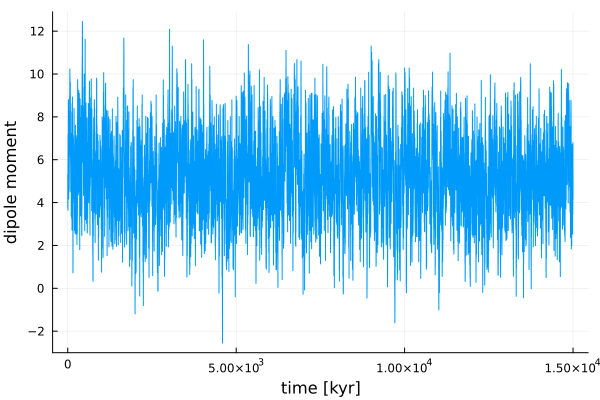

In [9]:
dt = 0.025
n = 600000

t,x = Langevin(γ,D,xbar,dt,n)

# decimate ?
decimate = 5;
xd = x[1:decimate:end]
td = t[1:decimate:end]

plot(td,xd,
    xlabel="time [kyr]",
    ylabel="dipole moment",
    legend=nothing)

Compute standard deviation of trends

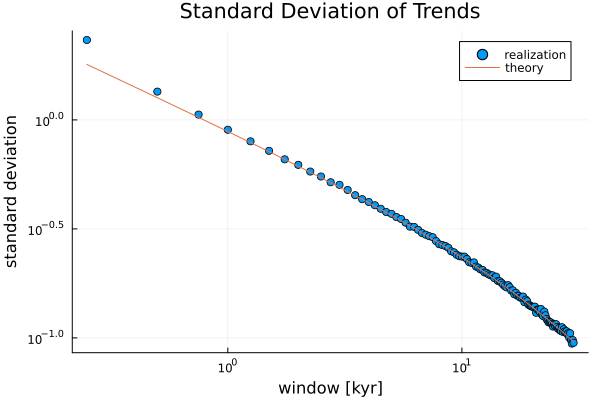

In [10]:
    nwindows = 120
    window,sd = trends(nwindows,td,xd)

    # theory
    σ_b = theory(γ,window,D)

    plot(window,sd,
    st=:scatter,
    xaxis=:log10,
    yaxis=:log10,
    xlabel="window [kyr]",
    ylabel="standard deviation",
    title="Standard Deviation of Trends",
    label="realization")

    plot!(window,σ_b,label="theory")